In [1]:
import pandas as pd          
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.concat(map(pd.read_csv, ['tennis_atp/atp_matches_2018.csv','tennis_atp/atp_matches_2019.csv', 'tennis_atp/atp_matches_2020.csv','tennis_atp/atp_matches_2021.csv','tennis_atp/atp_matches_2022.csv','tennis_atp/atp_matches_2023.csv','tennis_atp/atp_matches_2024.csv']))

In [3]:
# Remove identifying data
df = df.drop(columns=['winner_id', 'winner_name', 'winner_ioc', 
                      'loser_id', 'loser_name', 'loser_ioc', 
                      'tourney_id', 'tourney_name', 'tourney_level', 
                      'tourney_date', 'match_num', 'winner_seed', 
                      'winner_entry', 'loser_seed', 'loser_entry','score'])

In [4]:
# Check for missing values.
print(df.isnull().sum())

# There are zero duplicates
print(df.duplicated().sum())

# Drop any rows with nulls in them
df = df.dropna()

# Check 
row_count = len(df)
print(row_count)

surface                 53
draw_size                0
winner_hand              0
winner_ht               79
winner_age               3
loser_hand               1
loser_ht               227
loser_age                3
best_of                  0
round                    0
minutes               1033
w_ace                  694
w_df                   694
w_svpt                 694
w_1stIn                694
w_1stWon               694
w_2ndWon               694
w_SvGms                694
w_bpSaved              694
w_bpFaced              694
l_ace                  694
l_df                   694
l_svpt                 694
l_1stIn                694
l_1stWon               694
l_2ndWon               694
l_SvGms                694
l_bpSaved              694
l_bpFaced              694
winner_rank             79
winner_rank_points      79
loser_rank             222
loser_rank_points      222
dtype: int64
2
17547


In [5]:
winner_encoder = LabelEncoder()
loser_encoder = LabelEncoder()
surface_encoder = LabelEncoder()
round_encoder = LabelEncoder()


df['winner_hand'] = winner_encoder.fit_transform(df['winner_hand'])
df['loser_hand'] = loser_encoder.fit_transform(df['loser_hand'])
df['surface'] = surface_encoder.fit_transform(df['surface'])
df['round'] = round_encoder.fit_transform(df['round'])

In [6]:
# Convert features to not be associated with winning or losing
df = df.rename(columns={
    'winner_age': 'p1_age',
    'winner_seed': 'p1_seed',
    'winner_entry': 'p1_entry',
    'winner_ht': 'p1_ht',
    'winner_hand': 'p1_hand',
    'winner_rank': 'p1_rank',
    'winner_rank_points': 'p1_rank_points',
    'loser_age': 'p2_age',
    'loser_ht': 'p2_ht',
    'loser_hand': 'p2_hand',
    'loser_rank': 'p2_rank',
    'loser_rank_points': 'p2_rank_points'
})

# Ensure that player 1 is not always winning by swapping values
swap_mask = np.random.rand(len(df)) > 0.5
for col in ['age', 'ht', 'hand', 'rank', 'rank_points']:
    df.loc[swap_mask, f'p1_{col}'], df.loc[swap_mask, f'p2_{col}'] = df.loc[swap_mask, f'p2_{col}'], df.loc[swap_mask, f'p1_{col}']

# If a swap occured player 2 has won otherwise player 1 has won
# Using labels of 0 and 1 for binary encoding
df['winner'] = np.where(swap_mask, 1, 0)
df['winner'].value_counts()

winner
1    8789
0    8758
Name: count, dtype: int64

In [7]:
# Display the first and last few rows of the dataset.
display(df.head())
display(df.tail())

# Display the info of the dataset.
display(df.info())

# Display summary statistics of the dataset.
display(df.describe())

,surface,draw_size,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,best_of,round,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
0,2,32,1,185.0,25.6,1,188.0,30.6,3,5,...,33.0,19.0,14.0,1.0,4.0,47.0,1010.0,52.0,909.0,0
1,2,32,1,188.0,21.2,1,183.0,23.7,3,5,...,25.0,7.0,9.0,7.0,11.0,54.0,890.0,94.0,593.0,0
2,2,32,1,175.0,25.6,1,185.0,31.3,3,5,...,37.0,29.0,15.0,10.0,16.0,30.0,1391.0,63.0,809.0,1
3,2,32,1,183.0,18.8,1,188.0,28.0,3,5,...,33.0,17.0,11.0,4.0,6.0,208.0,245.0,44.0,1055.0,0
4,2,32,1,188.0,19.9,0,193.0,27.2,3,5,...,28.0,5.0,9.0,0.0,2.0,175.0,299.0,68.0,755.0,0


,surface,draw_size,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,best_of,round,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
3064,2,4,1,183.0,28.2,1,175.0,25.0,3,7,...,19.0,5.0,8.0,5.0,9.0,819.0,24.0,569.0,64.0,1
3066,2,4,1,178.0,31.0,1,188.0,28.8,3,7,...,17.0,9.0,8.0,2.0,5.0,279.0,205.0,900.0,18.0,0
3068,0,4,1,188.0,21.8,0,185.0,23.9,3,7,...,24.0,18.0,12.0,8.0,16.0,740.0,34.0,616.0,55.0,1
3070,0,4,0,185.0,23.9,1,175.0,34.2,3,7,...,33.0,6.0,8.0,6.0,11.0,616.0,55.0,136.0,489.0,1
3074,2,4,1,185.0,27.3,1,175.0,26.9,3,7,...,32.0,17.0,14.0,5.0,9.0,416.0,109.0,554.0,67.0,1


<class 'pandas.core.frame.DataFrame'>
Index: 17547 entries, 0 to 3074
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   surface         17547 non-null  int64  
 1   draw_size       17547 non-null  int64  
 2   p1_hand         17547 non-null  int64  
 3   p1_ht           17547 non-null  float64
 4   p1_age          17547 non-null  float64
 5   p2_hand         17547 non-null  int64  
 6   p2_ht           17547 non-null  float64
 7   p2_age          17547 non-null  float64
 8   best_of         17547 non-null  int64  
 9   round           17547 non-null  int64  
 10  minutes         17547 non-null  float64
 11  w_ace           17547 non-null  float64
 12  w_df            17547 non-null  float64
 13  w_svpt          17547 non-null  float64
 14  w_1stIn         17547 non-null  float64
 15  w_1stWon        17547 non-null  float64
 16  w_2ndWon        17547 non-null  float64
 17  w_SvGms         17547 non-null  float

None

,surface,draw_size,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,best_of,round,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
count,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,...,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000
mean,1.304383,62.260785,0.859805,187.248020,27.113763,0.861458,187.209438,27.161321,3.371232,4.592694,...,34.013735,14.723713,12.503733,4.770217,8.453012,79.386448,1532.155582,79.644840,1525.179803,0.500883
std,0.893933,42.604316,0.347199,7.091144,4.605259,0.345478,7.101619,4.539133,0.777615,1.601286,...,14.401328,6.902797,4.203480,3.282107,4.148517,108.755933,1729.053574,107.447231,1719.264916,0.500013
min,0.000000,2.000000,0.000000,15.000000,16.500000,0.000000,15.000000,16.400000,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,32.000000,1.000000,183.000000,23.600000,1.000000,183.000000,23.700000,3.000000,4.000000,...,24.000000,10.000000,9.000000,2.000000,5.000000,25.000000,643.500000,26.000000,644.000000,0.000000
50%,2.000000,32.000000,1.000000,188.000000,26.700000,1.000000,188.000000,26.800000,3.000000,5.000000,...,32.000000,14.000000,12.000000,4.000000,8.000000,55.000000,952.000000,55.000000,946.000000,1.000000
75%,2.000000,128.000000,1.000000,193.000000,30.300000,1.000000,193.000000,30.300000,3.000000,6.000000,...,42.000000,19.000000,15.000000,7.000000,11.000000,94.000000,1640.000000,94.000000,1627.500000,1.000000
max,2.000000,128.000000,1.000000,211.000000,42.500000,1.000000,211.000000,42.300000,5.000000,8.000000,...,171.000000,52.000000,50.000000,27.000000,38.000000,1921.000000,12415.000000,2146.000000,12415.000000,1.000000


In [8]:
# Check for missing values.
print(df.isnull().sum())

# There are zero duplicates
print(df.duplicated().sum())

surface           0
draw_size         0
p1_hand           0
p1_ht             0
p1_age            0
p2_hand           0
p2_ht             0
p2_age            0
best_of           0
round             0
minutes           0
w_ace             0
w_df              0
w_svpt            0
w_1stIn           0
w_1stWon          0
w_2ndWon          0
w_SvGms           0
w_bpSaved         0
w_bpFaced         0
l_ace             0
l_df              0
l_svpt            0
l_1stIn           0
l_1stWon          0
l_2ndWon          0
l_SvGms           0
l_bpSaved         0
l_bpFaced         0
p1_rank           0
p1_rank_points    0
p2_rank           0
p2_rank_points    0
winner            0
dtype: int64
0


In [9]:
# Drop any rows with nulls in them
df = df.dropna()

# Check 
row_count = len(df)
print(row_count)

17547


In [10]:
scaler = StandardScaler()
y = df['winner'].values

X = df.drop(columns=['winner'])
scaler = StandardScaler()
X = scaler.fit_transform(X)

display(y)
display(X)

array([0, 0, 1, ..., 1, 1, 1], shape=(17547,))

array([[ 0.77817611, -0.71029536,  0.40379981, ..., -0.30199785,
        -0.25729493, -0.35840745],
       [ 0.77817611, -0.71029536,  0.40379981, ..., -0.37140196,
         0.13360576, -0.54221217],
       [ 0.77817611, -0.71029536,  0.40379981, ..., -0.08163981,
        -0.15491617, -0.4165735 ],
       ...,
       [-1.45919178, -1.36752451,  0.40379981, ..., -0.86648459,
         4.99194292, -0.85514552],
       [-1.45919178, -1.36752451, -2.47647468, ..., -0.85433887,
         0.52450646, -0.60270487],
       [ 0.77817611, -1.36752451,  0.40379981, ..., -0.82310702,
         4.41489904, -0.8481656 ]], shape=(17547, 33))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
display(y_train)

array([0, 1, 0, ..., 1, 0, 1], shape=(14037,))

Accuracy: 0.6324786324786325
Precision: 0.6375496313102665
Recall: 0.6332394366197183
F1 Score: 0.6353872244205766
(14037, 33)


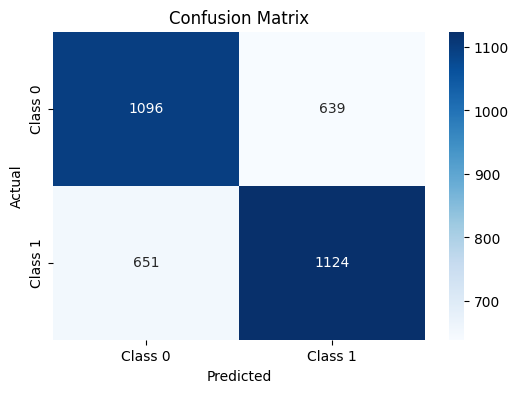

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

precision = precision_score(y_test, y_pred, average='binary')
print(f"Precision: {precision}")

recall = recall_score(y_test, y_pred, average='binary')
print(f"Recall: {recall}")

f1 = f1_score(y_test, y_pred, average='binary')
print(f"F1 Score: {f1}")

print(X_train.shape)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy: 0.6270655270655271
Precision: 0.6375496313102665
Recall: 0.6332394366197183
F1 Score: 0.6353872244205766
(14037, 33)


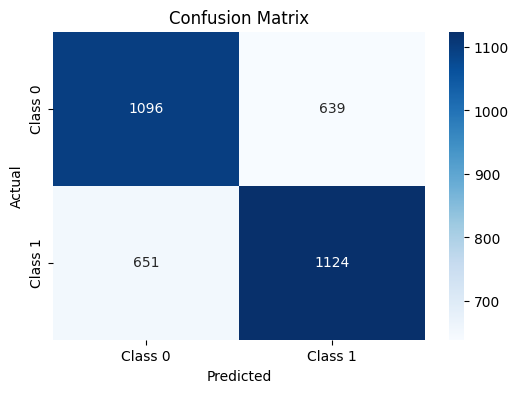

In [13]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)
clf.fit(X, y)
accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

precision = precision_score(y_test, y_pred, average='binary')
print(f"Precision: {precision}")

recall = recall_score(y_test, y_pred, average='binary')
print(f"Recall: {recall}")

f1 = f1_score(y_test, y_pred, average='binary')
print(f"F1 Score: {f1}")

print(X_train.shape)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy: 0.6652421652421653
Precision: 0.6675977653631285
Recall: 0.6732394366197183
F1 Score: 0.6704067321178121


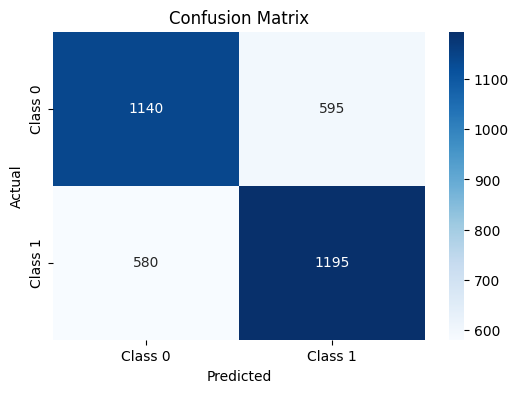

In [14]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100,max_depth=10, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

precision = precision_score(y_test, y_pred, average='binary')
print(f"Precision: {precision}")

recall = recall_score(y_test, y_pred, average='binary')
print(f"Recall: {recall}")

f1 = f1_score(y_test, y_pred, average='binary')
print(f"F1 Score: {f1}")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted');
plt.ylabel('Actual');